In [2]:
# Standard imports
import os
import torch
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os

# Imports for displaying vis in Colab / notebook

torch.set_grad_enabled(False)

# For the most part I'll try to import functions and classes near where they are used
# to make it clear where they come from.

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda


In [3]:
# from transformer_lens import HookedTransformer
from sae_lens import SAE, HookedSAETransformer

model = HookedSAETransformer.from_pretrained("gpt2-small", device = device)

# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience.
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gpt2-small-res-jb", # <- Release name
    sae_id = "blocks.7.hook_resid_pre", # <- SAE id (not always a hook point!)
    device = device
)

/home/hasith/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
import json
import os

def find_json_file(n, directory='.'):
    best_file = None
    best_end = None

    # List all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            # Extract the range from the filename
            start, end = map(int, filename.rstrip('.json').split('-'))

            # Check if n is within the range
            if start <= n <= end:
                if best_file is None or end > best_end or (end == best_end and n == end):
                    best_file = filename
                    best_end = end

    return best_file, n-int(best_file.rstrip('.json').split('-')[0])

def load_json_from_file(filename):
    with open(filename, 'r') as file:
        return json.load(file)

def load_json_from_feature(feature, directory='.'):
    json_file, m = find_json_file(feature, directory)
    return load_json_from_file(os.path.join(directory, json_file))[m]


In [5]:
# Initialze empty array of size total_features, total_features
neg_feature_mat = torch.zeros((24576, 24576))
pos_feature_mat = torch.zeros((24576, 24576))
total_features = 24576

In [13]:
files = os.listdir("./data/")
for f in tqdm(files):
    file = os.path.join("./data/", f)
    start, end = map(int, f.rstrip('.json').split('-'))
    jsondata = load_json_from_file(file)
    for j in range(start, end):
        i = j - start
        word_neg = jsondata[i]['neg_str'][0]
        word_pos = jsondata[i]['pos_str'][0]

        input_id_neg = model.to_tokens(word_neg, prepend_bos=False)[:,[0]]
        input_id_pos = model.to_tokens(word_pos, prepend_bos=False)[:,[0]]

        # Negative
        _, cache = model.run_with_cache(
            input_id_neg,
            stop_at_layer=sae.cfg.hook_layer + 1,
            names_filter=[sae.cfg.hook_name]
        )
        sae_in = cache[sae.cfg.hook_name]
        feature_acts = sae.encode(sae_in).squeeze()

        assert feature_acts.shape == (total_features,)
        neg_feature_mat[j,:] = feature_acts

        # Positive
        _, cache = model.run_with_cache(
            input_id_pos,
            stop_at_layer=sae.cfg.hook_layer + 1,
            names_filter=[sae.cfg.hook_name]
        )
        sae_in = cache[sae.cfg.hook_name]
        feature_acts = sae.encode(sae_in).squeeze()

        assert feature_acts.shape == (total_features,)
        pos_feature_mat[j,:] = feature_acts


100%|██████████| 192/192 [23:16<00:00,  7.27s/it]


In [14]:
# save the feature matrix
with open('raw_neg_feature_mat.pkl', 'wb') as f:
    # make sparse
    raw_neg_feature_mat_sparse = neg_feature_mat.to_sparse()
    pickle.dump(raw_neg_feature_mat_sparse, f)

with open('raw_pos_feature_mat.pkl', 'wb') as f:
    # make sparse
    raw_pos_feature_mat_sparse = pos_feature_mat.to_sparse()
    pickle.dump(raw_pos_feature_mat_sparse, f)

In [7]:
# load the feature matrix
with open('raw_neg_feature_mat.pkl', 'rb') as f:
    raw_neg_feature_mat_sparse = pickle.load(f)
    neg_feature_mat = raw_neg_feature_mat_sparse.to_dense()

with open('raw_pos_feature_mat.pkl', 'rb') as f:
    raw_pos_feature_mat_sparse = pickle.load(f)
    pos_feature_mat = raw_pos_feature_mat_sparse.to_dense()

/home/hasith/anaconda3/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [8]:
# Make a tensor of the same shape as the feature matrices, with elements that are the maxActApprox of the jth feature
import numpy as np

# list of files in directory
directory = "./data/"
file_list = os.listdir(directory)
maxActApprox = torch.zeros((total_features,))
for f in tqdm(file_list):
    file = os.path.join(directory, f)
    start, end = map(int, f.rstrip('.json').split('-'))
    jsondata = load_json_from_file(file)
    for i in range(start, end):
        maxActApprox[i] = max(np.abs(jsondata[i-start]['maxActApprox']), float(torch.max(torch.abs(pos_feature_mat[:,i]))), float(torch.max(torch.abs(neg_feature_mat[:,i]))))

# maxActApprox = torch.tensor([load_json_from_feature(j, directory)['maxActApprox'] for j in tqdm(range(total_features))])
maxActApprox = maxActApprox.unsqueeze(0).repeat(total_features, 1)

100%|██████████| 192/192 [00:56<00:00,  3.42it/s]


In [12]:
# count number of zeroes in maxActApprox
max_zeroes_count = torch.sum(maxActApprox[0,:] == 0).item()
print(f"Number of zeroes in maxActApprox: {max_zeroes_count}")

# Drop the zero rows and columns from the matrices later on
nonzero_max_features = ~(maxActApprox[0,:] == 0)

# count number of columns in the matrices that are all zero
neg_num_zero_cols = torch.sum(torch.all(neg_feature_mat == 0, dim=0)).item()
pos_num_zero_cols = torch.sum(torch.all(pos_feature_mat == 0, dim=0)).item()
print(f"Number of zero columns in neg_feature_mat: {neg_num_zero_cols}")
print(f"Number of zero columns in pos_feature_mat: {pos_num_zero_cols}")

# Drop the zero columns from the matrices later on
nonzero_neg_res_features = ~(torch.all(neg_feature_mat == 0, dim=0)) 
nonzero_pos_res_features = ~(torch.all(pos_feature_mat == 0, dim=0))

# Keep only these features
# good_features = torch.logical_and(nonzero_act_features, nonzero_res_features)
good_pos = torch.logical_and(nonzero_max_features, nonzero_pos_res_features)
good_neg = torch.logical_and(nonzero_max_features, nonzero_neg_res_features)


Number of zeroes in maxActApprox: 5
Number of zero columns in neg_feature_mat: 24576
Number of zero columns in pos_feature_mat: 24576


In [10]:
sum(good_pos), sum(good_neg)

(tensor(0), tensor(0))

/home/hasith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/hasith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

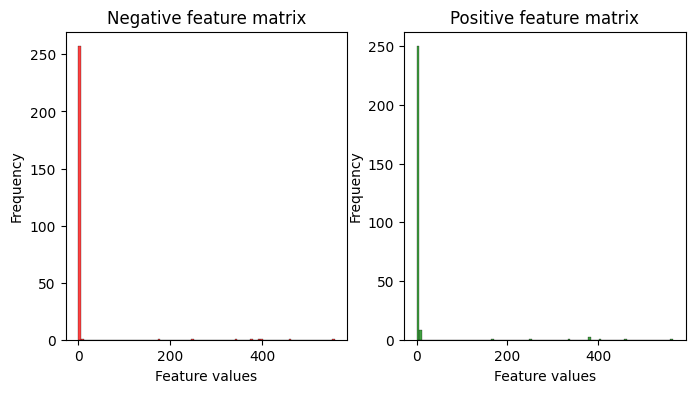

In [111]:
# plot histograms of the feature matrices
import matplotlib.pyplot as plt
import seaborn as sns

np_neg_feature_mat = neg_feature_mat.numpy()[good_neg,good_pos]
np_pos_feature_mat = pos_feature_mat.numpy()[good_pos,good_pos]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(np_neg_feature_mat, bins=100, color='red')
plt.title("Negative feature matrix")
plt.xlabel("Feature values")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(np_pos_feature_mat, bins=100, color='green')
plt.title("Positive feature matrix")
plt.xlabel("Feature values")
plt.ylabel("Frequency")

In [112]:
# Element-wise division of the feature matrices by the maxActApprox tensor
normed_neg_feature_mat = neg_feature_mat / maxActApprox
normed_pos_feature_mat = pos_feature_mat / maxActApprox

In [ ]:
# plot histograms of the normed feature matrices
np_normed_neg_feature_mat = normed_neg_feature_mat.numpy()[good_neg,good_neg]
np_normed_pos_feature_mat = normed_pos_feature_mat.numpy()[good_pos,good_pos]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(np_normed_neg_feature_mat, bins=100, color='red')
plt.title("Negative normed feature matrix")
plt.xlabel("Feature values")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(np_normed_pos_feature_mat, bins=100, color='green')
plt.title("Positive normed feature matrix")
plt.xlabel("Feature values")
plt.ylabel("Frequency")

In [14]:
import pickle

# save the feature matrix
with open('neg_feature_mat.pkl', 'wb') as f:
    # make sparse
    normed_neg_feature_mat_sparse = normed_neg_feature_mat.to_sparse()
    pickle.dump(normed_neg_feature_mat_sparse, f)

with open('pos_feature_mat.pkl', 'wb') as f:
    # make sparse
    normed_pos_feature_mat_sparse = normed_pos_feature_mat.to_sparse()
    pickle.dump(normed_pos_feature_mat_sparse, f)


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Load the feature matrix
with open('pos_feature_mat.pkl', 'rb') as f:
    normed_pos_feature_mat_sparse = pickle.load(f)

with open('neg_feature_mat.pkl', 'rb') as f:
    normed_neg_feature_mat_sparse = pickle.load(f)


/home/hasith/anaconda3/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


/home/hasith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/hasith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

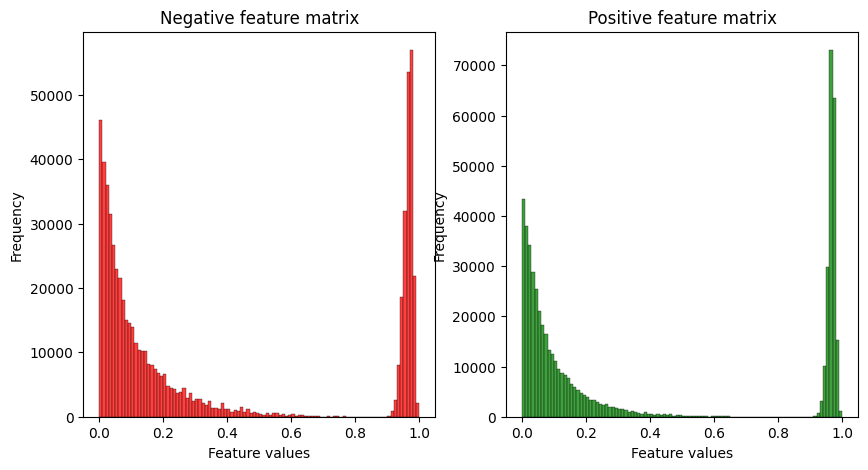

In [116]:
# plot histograms of the feature matrices
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(normed_neg_feature_mat_sparse.values(), bins=100, color='red')
plt.title("Negative feature matrix")
plt.xlabel("Feature values")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(normed_pos_feature_mat_sparse.values(), bins=100, color='green')
plt.title("Positive feature matrix")
plt.xlabel("Feature values")
plt.ylabel("Frequency")

In [89]:
import numpy as np
import pandas as pd

def group_sparse_matrix(sparse_matrix, group_size):
    """
    Groups a square sparse matrix by summing up sub-blocks, handling cases where the matrix dimensions
    are not evenly divisible by the group size.

    Parameters:
    sparse_matrix (torch.sparse.FloatTensor): The original ungrouped sparse matrix.
    group_size (int): The size of each group in the new matrix.

    Returns:
    torch.Tensor: The grouped matrix as a dense tensor.
    """
    # Convert sparse tensor to dense format
    dense_matrix = sparse_matrix.to_dense()

    # Determine the number of groups
    rows, cols = dense_matrix.size()
    num_groups_x = (rows + group_size - 1) // group_size  # Ceiling division for rows
    num_groups_y = (cols + group_size - 1) // group_size  # Ceiling division for columns

    # Initialize the new grouped matrix
    grouped_matrix = torch.zeros((num_groups_x, num_groups_y))
    group_ranges = []

    # Group the matrix by summing sub-blocks
    for i in range(num_groups_x):
        for j in range(num_groups_y):
            # Determine the sub-block limits, taking care not to exceed the matrix bounds
            row_start = i * group_size
            row_end = min((i + 1) * group_size, rows)
            col_start = j * group_size
            col_end = min((j + 1) * group_size, cols)

            # Sum the sub-block
            grouped_matrix[i, j] = dense_matrix[row_start:row_end, col_start:col_end].sum()
        group_ranges.append(str(row_start) + '-' + str(row_end))

    return grouped_matrix, group_ranges


def matrix_to_dataframe(matrix, ranges):
    """
    Converts a square NumPy array into a Pandas DataFrame with columns "source", "target", and "weight".
    
    Parameters:
    matrix (np.array): The square matrix to convert.
    
    Returns:
    pd.DataFrame: The resulting DataFrame.
    """
    # Get the indices and values
    rows, cols = matrix.shape
    sources, targets = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    
    # Flatten the arrays to create a long-format DataFrame
    # sources = sources.flatten()
    sources = [ranges[i] for i in sources.flatten()]
    targets = [ranges[i] for i in targets.flatten()]
    weights = matrix.flatten()

    # Create the DataFrame
    df = pd.DataFrame({'source': sources, 'target': targets, 'weight': weights})
    
    return df

# Group the matrix
group_size = 1000  # The size of each group
pos_grouped_matrix, pos_grouped_ranges = group_sparse_matrix(torch.abs(normed_pos_feature_mat_sparse), group_size)
neg_grouped_matrix, neg_grouped_ranges = group_sparse_matrix(torch.abs(normed_neg_feature_mat_sparse), group_size)

In [90]:
pos_grouped_matrix.shape, neg_grouped_matrix.shape

# columns that are all non-nan
non_nan_pos = (~(torch.isnan(pos_grouped_matrix).all(dim=0))).tolist()
non_nan_neg = (~(torch.isnan(neg_grouped_matrix).all(dim=0))).tolist()

In [91]:
pos_grouped_matrix = pos_grouped_matrix[non_nan_pos, :][:, non_nan_pos]
neg_grouped_matrix = neg_grouped_matrix[non_nan_neg, :][:, non_nan_neg]
pos_grouped_ranges = [pos_grouped_ranges[i] for i in range(len(pos_grouped_ranges)) if non_nan_pos[i]]

In [92]:
pos_grouped_matrix.shape, neg_grouped_matrix.shape

(torch.Size([20, 20]), torch.Size([20, 20]))

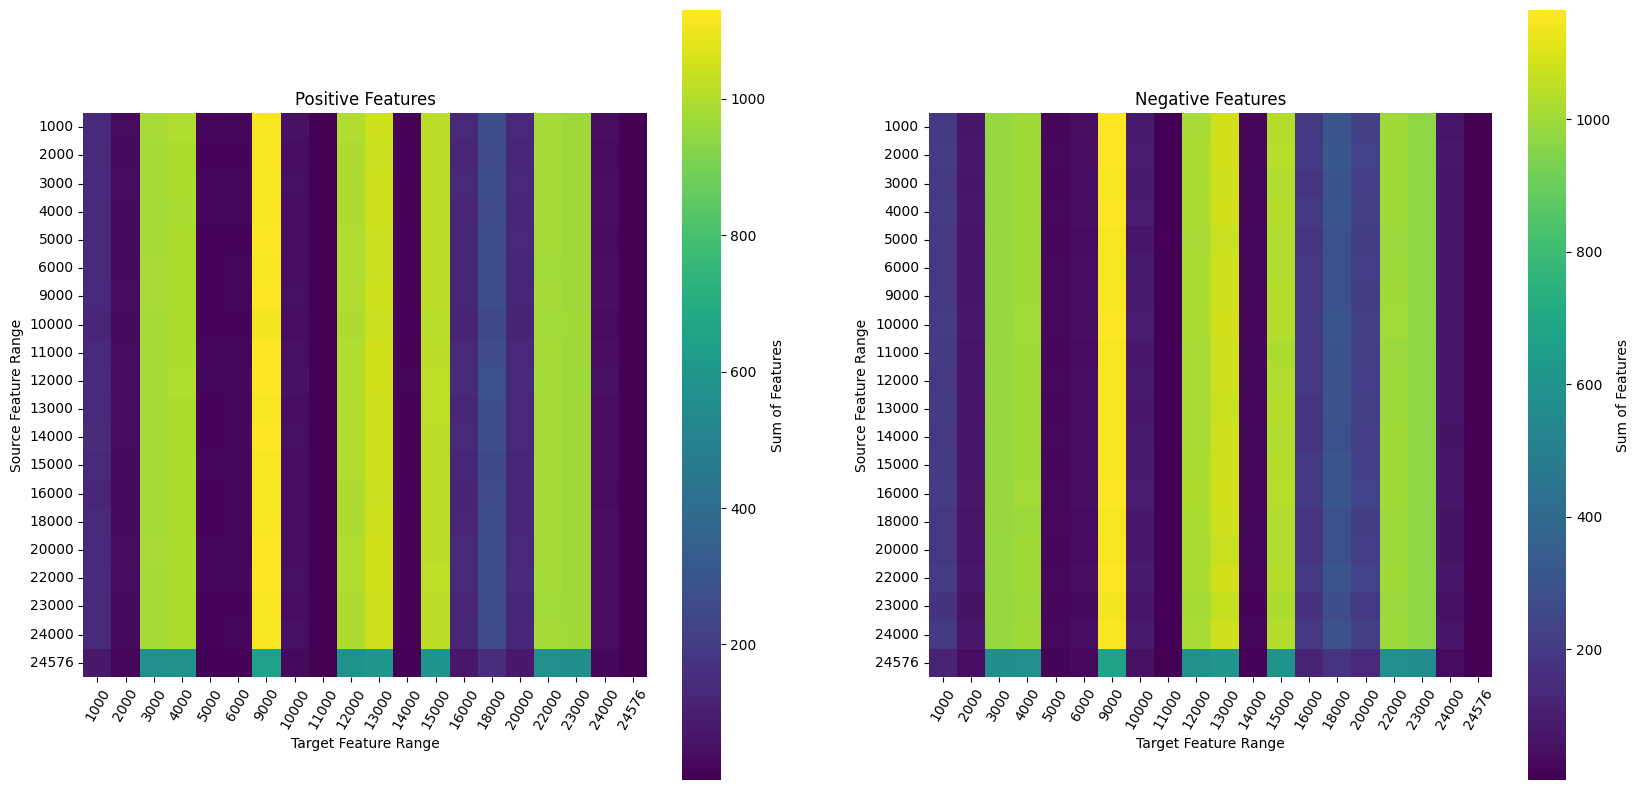

In [93]:
# Make all non-zero values equal to 1
# grouped_matrix[grouped_matrix > 0.1] = 1

# Make heatmaps of the grouped matrix with subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(pos_grouped_matrix, cmap='viridis', square=True, cbar_kws={'label': 'Sum of Features'}, ax=axes[0])
sns.heatmap(neg_grouped_matrix, cmap='viridis', square=True, cbar_kws={'label': 'Sum of Features'}, ax=axes[1])

# Set the titles
axes[0].set_title('Positive Features')
axes[1].set_title('Negative Features')

# Set the labels
axes[0].set_xlabel('Target Feature Range')
axes[1].set_xlabel('Target Feature Range')
axes[0].set_ylabel('Source Feature Range')
axes[1].set_ylabel('Source Feature Range')

# Set the ticks to be the first number in the group 
second_nums = [int(r.split('-')[1]) for r in pos_grouped_ranges]
axes[0].set_xticklabels(second_nums, rotation=60);
axes[0].set_yticklabels(second_nums, rotation=0);
axes[1].set_xticklabels(second_nums, rotation=60);
axes[1].set_yticklabels(second_nums, rotation=0);


ValueError: The number of FixedLocator locations (36), usually from a call to set_ticks, does not match the number of labels (24576).

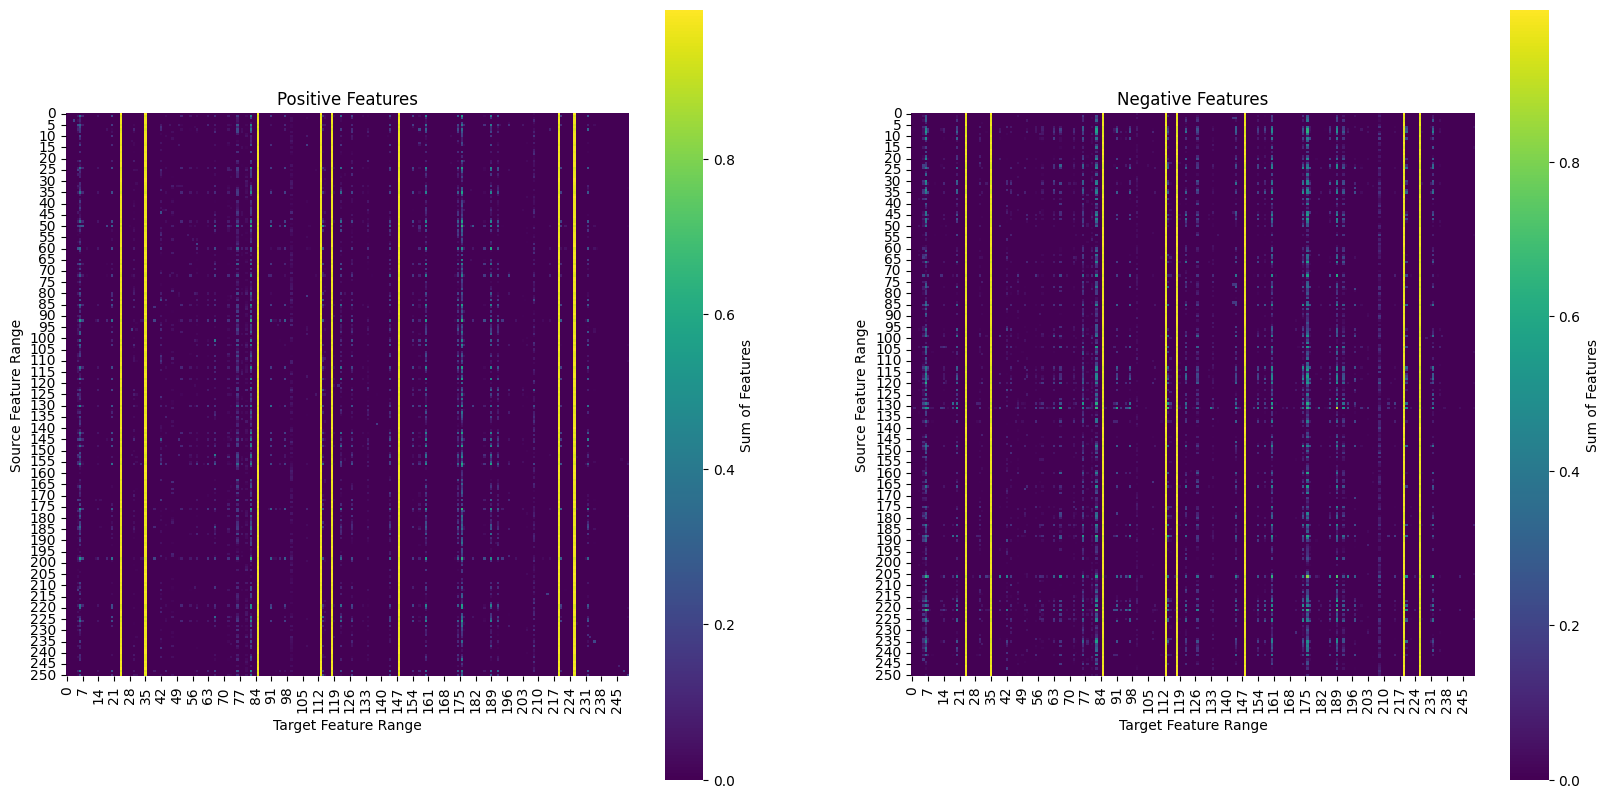

In [95]:
# Make all non-zero values equal to 1
# grouped_matrix[grouped_matrix > 0.1] = 1

# Make heatmaps of the grouped matrix with subplots
normed_neg_feature_mat_dense = normed_neg_feature_mat_sparse.to_dense()
normed_pos_feature_mat_dense = normed_pos_feature_mat_sparse.to_dense()

relevant_neg = normed_neg_feature_mat_dense[good_features, :][:, good_features]
relevant_pos = normed_pos_feature_mat_dense[good_features, :][:, good_features]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(relevant_pos, cmap='viridis', square=True, cbar_kws={'label': 'Sum of Features'}, ax=axes[0])
sns.heatmap(relevant_neg, cmap='viridis', square=True, cbar_kws={'label': 'Sum of Features'}, ax=axes[1])

# Set the titles
axes[0].set_title('Positive Features')
axes[1].set_title('Negative Features')

# Set the labels
axes[0].set_xlabel('Target Feature Range')
axes[1].set_xlabel('Target Feature Range')
axes[0].set_ylabel('Source Feature Range')
axes[1].set_ylabel('Source Feature Range')

# Set the ticks to be the first number in the group 
second_nums = good_features
axes[0].set_xticklabels(second_nums, rotation=60);
axes[0].set_yticklabels(second_nums, rotation=0);
axes[1].set_xticklabels(second_nums, rotation=60);
axes[1].set_yticklabels(second_nums, rotation=0);

In [61]:
# Display the feature matrix as a chord diagram
import numpy as np
from d3blocks import D3Blocks

# Initialize
d3 = D3Blocks()

# Load example data
M_pos = pos_grouped_matrix.numpy()
df_pos = matrix_to_dataframe(M_pos, pos_grouped_ranges)

M_neg = neg_grouped_matrix.numpy()
df_neg = matrix_to_dataframe(M_neg, neg_grouped_ranges)

# d3.chord(df)
d3.chord(df_pos, filepath="./pos_feature_matrix.html", ordering=pos_grouped_ranges)
d3.chord(df_neg, filepath="./neg_feature_matrix.html", ordering=neg_grouped_ranges)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/home/hasith/projects/sae_tut/ARENA_3.0/chapter1_transformer_interp/exercises/part4_superposition_and_saes/pos_feature_matrix.html]
[d3blocks] >INFO> Convert to DataFrame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/home/hasith/projects/sae_tut/ARENA_3.0/chapter1_transformer_interp/exercises/part4_superposition_and_saes/pos_feature_matrix.html]
[d3blocks] >INFO> Open browser: /home/hasith/projects/sae_tut/ARENA_3.0/chapter1_transformer_interp/exercises/part4_superposition_and_saes/pos_feature_matrix.html
[d3blocks] >INFO> Cleaning edge_p

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
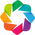

:Chord   [source,target]   (weight)

In [43]:
import holoviews as hv
from holoviews import opts, dim

hv.extension('bokeh')
hv.output(size=200)

chord = hv.Chord(df)
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), labels='name', node_color=dim('index').str())
)